In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
import scipy
from scipy.stats import zscore
from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/eval{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '01_eval.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data_32k/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'valid_source', 'valid_target']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [10]:
# for train datasets
def get_target_names(wav_names):
    target_names = []
    for wav_name in wav_names:
        if 'target' in wav_name:
            target_names.append(wav_name)
    
    return target_names

# evaluation

## calc MVG (multivariate Gaussian)

In [11]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    
    mean = ext_data['train']['features'].mean(axis=0)
    cov_estimator = LedoitWolf()
    cov_estimator.fit(ext_data['train']['features'])
    cov = cov_estimator.covariance_
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov

com.toc()

elapsed time: 34.074960232 [sec]


## estimate

In [12]:
def calc_mahalanobis(mean, cov, samples):
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    dists = [mahalanobis(sample, mean, cov_inv) for sample in samples]
    # np.array
    dists = np.array(dists)
    return dists

In [13]:
from IPython.display import display

In [14]:
def get_score_perID(describe_df, max_fpr=0.1):
    # ユニークsectionを取得、昇順ソート
    sections = np.sort(describe_df['section_types'].unique())

    for section in sections:
        per_section_df = describe_df[describe_df['section_types'] == section]
        per_section_AUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'])
        per_section_pAUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'], max_fpr=max_fpr)
        # column = [AUC,pAUC], row = index
        score_df = pd.DataFrame(np.stack([per_section_AUC, per_section_pAUC]), index=['AUC', 'pAUC']).T
        # indexをsectionナンバーにrename
        # column = [AUC,pAUC], row = [section]
        score_df.index = [section]
        if section == 0:
            scores_df = score_df.copy()
        else:
            # 結合
            scores_df = scores_df.append(score_df)
    return scores_df

## Calc Score

In [15]:
for i, machine_type in enumerate(machine_types):
    logger.info('CALC SCORE')
    logger.info(machine_type)
    # get MVG
    tr_mean = MVG[machine_type]['mean']
    tr_cov = MVG[machine_type]['cov']
    # load samples
    ext_data = load_ext_data(machine_type)
    for phase in ['valid_source', 'valid_target']:
        # pred
        samples = ext_data[phase]['features']
        preds = calc_mahalanobis(tr_mean, tr_cov, samples)
        section_types = com.get_section_types(ext_data[phase]['wav_names'])
        # wavname + pred
        preds_pd = np.stack([np.array(ext_data[phase]['wav_names']), preds], axis=1)
        preds_pd = pd.DataFrame(preds_pd, columns=['wav_name', 'pred'])
        preds_pd.to_csv(OUT_PRED_DIR + f'/pred_{machine_type}_{phase}.csv')
        # dataframe作成
        describe_df = com.get_pred_discribe(labels=ext_data[phase]['labels'],
                                            preds=preds,
                                            section_types=section_types)
        # スコア算出(AUC, pAUC)
        scores_df = get_score_perID(describe_df, max_fpr=0.1)

        # 結合(source + target)
        if phase == 'valid_source':
            scores_df = scores_df.rename(index=lambda num: 'Source_' + f'{num}')
            all_scores_df = scores_df.copy()
        else:
            scores_df = scores_df.rename(index=lambda num: 'Target_' + f'{num}')
            all_scores_df = all_scores_df.append(scores_df)
            
    # 平均
    mean_df = pd.DataFrame(all_scores_df.mean(axis=0)).T
    mean_df.index = ['mean']
    # 調和平均
    hmean = scipy.stats.hmean(all_scores_df, axis=0)
    hmean_df = pd.DataFrame(hmean, index=['AUC', 'pAUC']).T
    hmean_df.index = ['h_mean']
    # 結合
    all_scores_df = all_scores_df.append(mean_df)
    all_scores_df = all_scores_df.append(hmean_df)
    # 出力
    all_scores_df.to_csv(f'{OUT_SCORE_DIR}/{machine_type}_score.csv')
    # display
    display(all_scores_df)

2021-04-17 01:06:24,442 - 01_eval.py - INFO - CALC SCORE
2021-04-17 01:06:24,446 - 01_eval.py - INFO - fan


,AUC,pAUC
Source_0,0.694300,0.607368
Source_1,0.525600,0.498947
Source_2,0.552700,0.500000
Target_0,0.714400,0.598421
Target_1,0.498300,0.494737
Target_2,0.539500,0.530526
mean,0.587467,0.538333
h_mean,0.576239,0.534382


2021-04-17 01:06:29,225 - 01_eval.py - INFO - CALC SCORE
2021-04-17 01:06:29,227 - 01_eval.py - INFO - gearbox


,AUC,pAUC
Source_0,0.677363,0.611079
Source_1,0.938443,0.811837
Source_2,0.721954,0.594104
Target_0,0.887153,0.752680
Target_1,0.951475,0.838730
Target_2,0.775317,0.640142
mean,0.825284,0.708095
h_mean,0.811355,0.694891


2021-04-17 01:06:34,702 - 01_eval.py - INFO - CALC SCORE
2021-04-17 01:06:34,703 - 01_eval.py - INFO - pump


,AUC,pAUC
Source_0,0.647200,0.645263
Source_1,0.608700,0.547895
Source_2,0.632400,0.591053
Target_0,0.512600,0.505263
Target_1,0.410600,0.477895
Target_2,0.582900,0.504737
mean,0.565733,0.545351
h_mean,0.551922,0.539582


2021-04-17 01:06:39,590 - 01_eval.py - INFO - CALC SCORE
2021-04-17 01:06:39,591 - 01_eval.py - INFO - slider


,AUC,pAUC
Source_0,0.748100,0.585789
Source_1,0.824000,0.713684
Source_2,0.770856,0.687588
Target_0,0.611600,0.581053
Target_1,0.573265,0.573362
Target_2,0.572376,0.567676
mean,0.683366,0.618192
h_mean,0.668589,0.612913


2021-04-17 01:06:44,508 - 01_eval.py - INFO - CALC SCORE
2021-04-17 01:06:44,509 - 01_eval.py - INFO - ToyCar


,AUC,pAUC
Source_0,0.741500,0.529474
Source_1,0.594900,0.534737
Source_2,0.765800,0.602105
Target_0,0.584000,0.548421
Target_1,0.687700,0.565263
Target_2,0.612700,0.538947
mean,0.664433,0.553158
h_mean,0.656889,0.552102


2021-04-17 01:06:49,356 - 01_eval.py - INFO - CALC SCORE
2021-04-17 01:06:49,357 - 01_eval.py - INFO - ToyTrain


,AUC,pAUC
Source_0,0.797300,0.675263
Source_1,0.637800,0.536316
Source_2,0.678000,0.478421
Target_0,0.806100,0.668947
Target_1,0.529300,0.488947
Target_2,0.635400,0.535263
mean,0.680650,0.563860
h_mean,0.666616,0.553300


2021-04-17 01:06:53,897 - 01_eval.py - INFO - CALC SCORE
2021-04-17 01:06:53,898 - 01_eval.py - INFO - valve


,AUC,pAUC
Source_0,0.534900,0.513158
Source_1,0.512300,0.490000
Source_2,0.625900,0.495263
Target_0,0.500600,0.488947
Target_1,0.717300,0.607368
Target_2,0.517000,0.505263
mean,0.568000,0.516667
h_mean,0.558392,0.513721


2021-04-17 01:07:02,527 - 01_eval.py - INFO - fan valid_source AUC : 0.5828111111111112
2021-04-17 01:07:02,531 - 01_eval.py - INFO - fan valid_target AUC : 0.5890333333333333


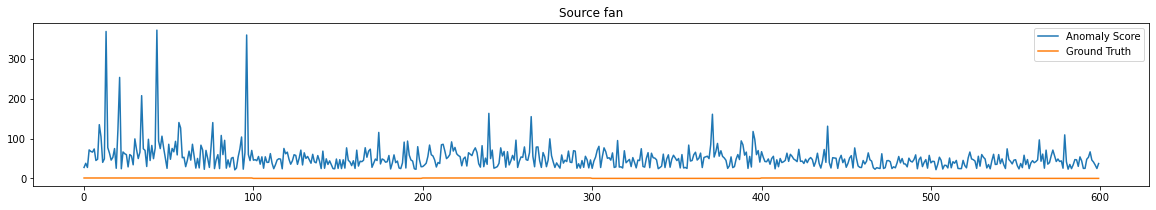

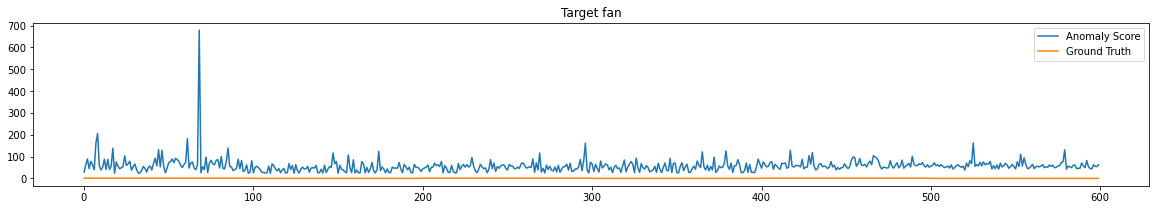

2021-04-17 01:07:06,948 - 01_eval.py - INFO - gearbox valid_source AUC : 0.7802732547258096
2021-04-17 01:07:06,951 - 01_eval.py - INFO - gearbox valid_target AUC : 0.8699626290645708


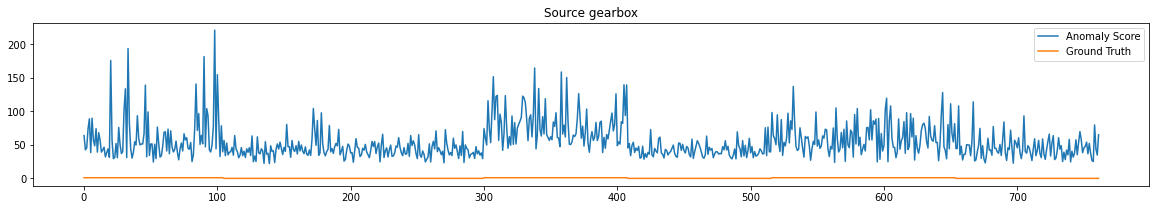

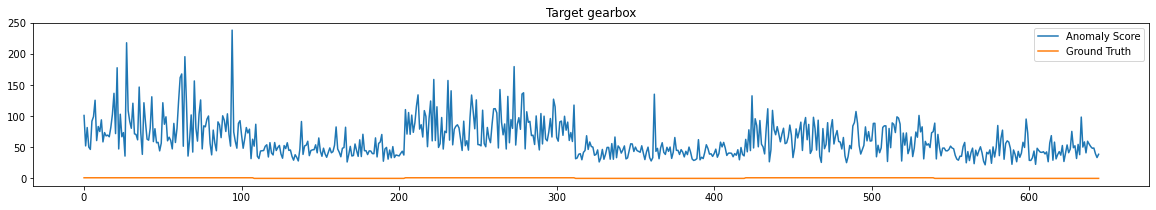

2021-04-17 01:07:10,926 - 01_eval.py - INFO - pump valid_source AUC : 0.6312111111111111
2021-04-17 01:07:10,928 - 01_eval.py - INFO - pump valid_target AUC : 0.5090444444444444


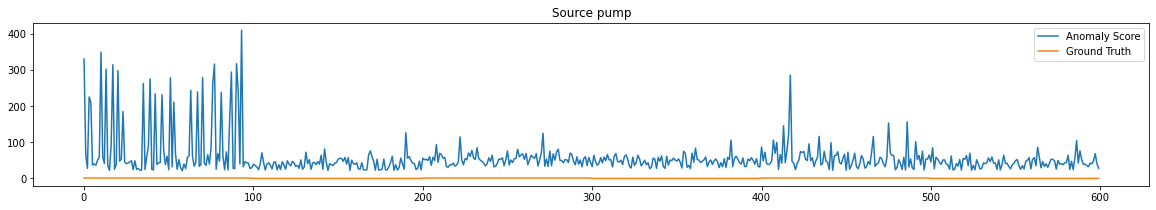

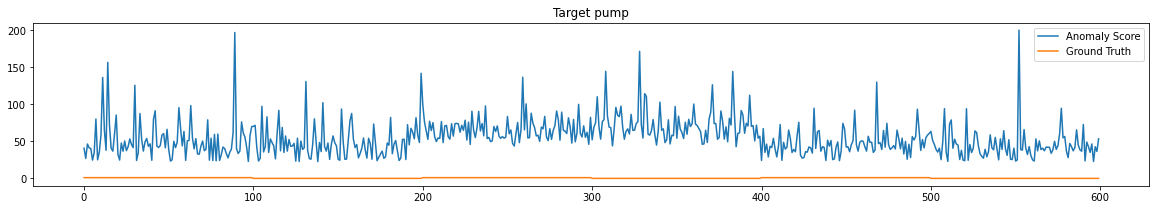

2021-04-17 01:07:15,023 - 01_eval.py - INFO - slider valid_source AUC : 0.7775688955351422
2021-04-17 01:07:15,026 - 01_eval.py - INFO - slider valid_target AUC : 0.5877704194260486


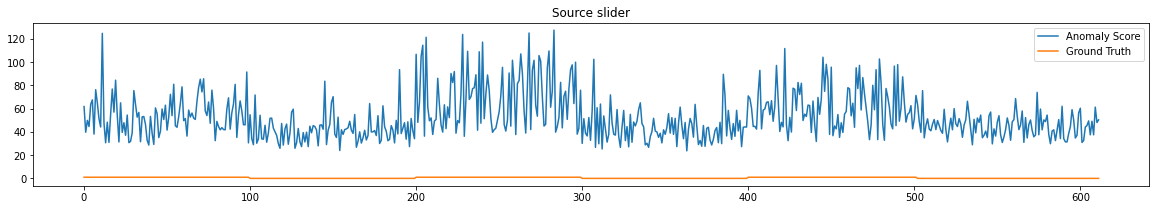

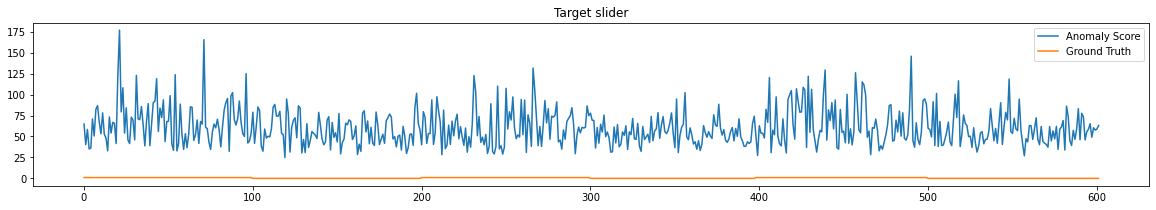

2021-04-17 01:07:19,018 - 01_eval.py - INFO - ToyCar valid_source AUC : 0.7019777777777777
2021-04-17 01:07:19,020 - 01_eval.py - INFO - ToyCar valid_target AUC : 0.5922777777777779


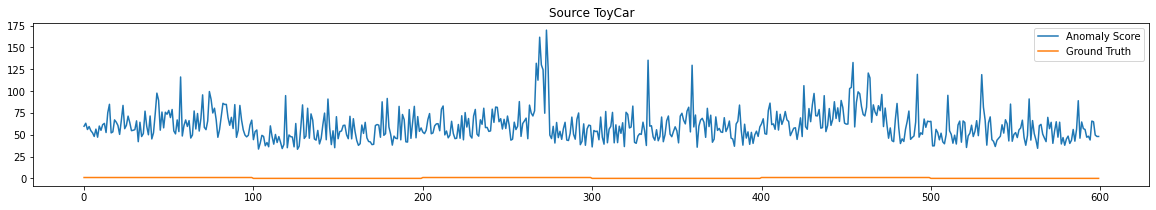

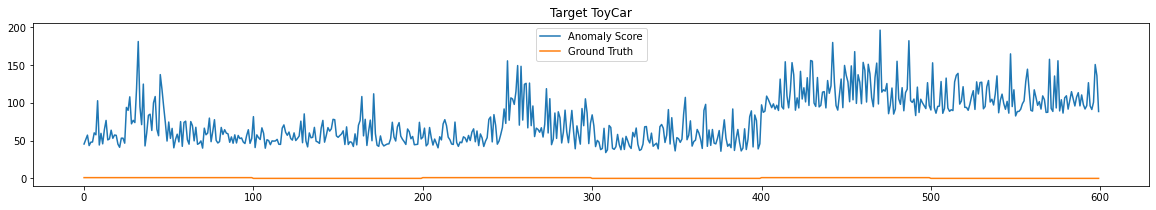

2021-04-17 01:07:22,871 - 01_eval.py - INFO - ToyTrain valid_source AUC : 0.6631444444444444
2021-04-17 01:07:22,873 - 01_eval.py - INFO - ToyTrain valid_target AUC : 0.6111777777777778


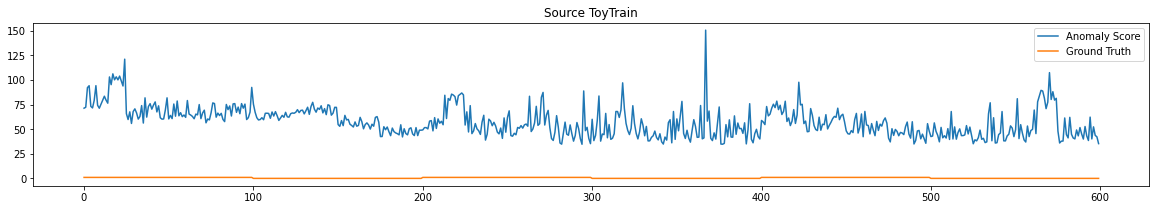

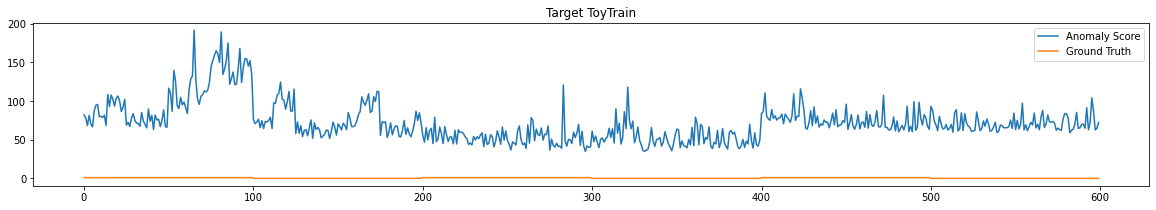

2021-04-17 01:07:26,734 - 01_eval.py - INFO - valve valid_source AUC : 0.5587222222222222
2021-04-17 01:07:26,736 - 01_eval.py - INFO - valve valid_target AUC : 0.5585777777777778


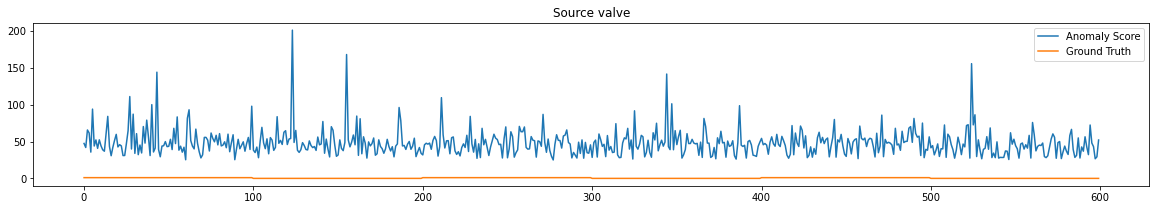

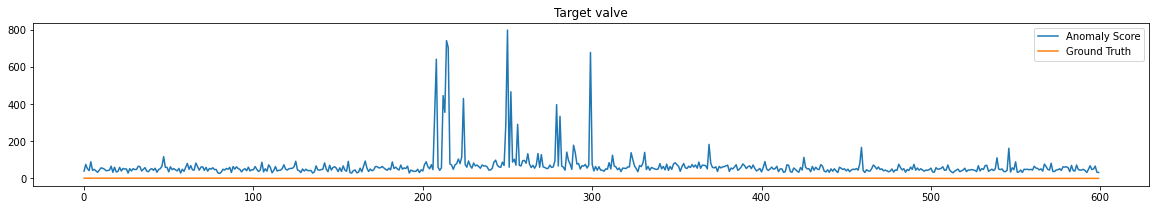

In [16]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [17]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [18]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

GaussianMixture(n_components=3, random_state=42)

In [19]:
gmm.bic(ext_data['train']['features'])

-64636139.68033038

In [20]:
pred = gmm.predict(ext_data['train']['features'])

(array([2048.,    0.,    0.,    0.,    0., 1838.,    0.,    0.,    0.,
        2132.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

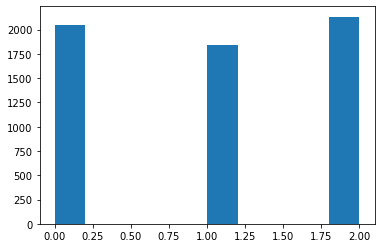

In [21]:
plt.hist(pred)

In [22]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [23]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [24]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

2021-04-17 01:08:08,365 - 01_eval.py - INFO - fan valid_source AUC : 0.47474444444444436
2021-04-17 01:08:08,368 - 01_eval.py - INFO - fan valid_target AUC : 0.48391111111111107
2021-04-17 01:08:11,558 - 01_eval.py - INFO - gearbox valid_source AUC : 0.4686297751991183
2021-04-17 01:08:11,560 - 01_eval.py - INFO - gearbox valid_target AUC : 0.46417013407304664
2021-04-17 01:08:14,171 - 01_eval.py - INFO - pump valid_source AUC : 0.43854444444444446
2021-04-17 01:08:14,173 - 01_eval.py - INFO - pump valid_target AUC : 0.5304333333333333
2021-04-17 01:08:16,748 - 01_eval.py - INFO - slider valid_source AUC : 0.47760093997009184
2021-04-17 01:08:16,751 - 01_eval.py - INFO - slider valid_target AUC : 0.49217439293598236
2021-04-17 01:08:19,212 - 01_eval.py - INFO - ToyCar valid_source AUC : 0.3443777777777778
2021-04-17 01:08:19,215 - 01_eval.py - INFO - ToyCar valid_target AUC : 0.2699666666666667
2021-04-17 01:08:21,417 - 01_eval.py - INFO - ToyTrain valid_source AUC : 0.5442333333333333

In [25]:
gmm_section_types = gmm.predict(feats)

NameError: name 'feats' is not defined

In [ ]:
sns.distplot(section_types)

In [ ]:
sns.displot(gmm_section_types)